In [1]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, AutoModelForSeq2SeqLM
from langchain.chains import RetrievalQA

c:\Users\milen\miniconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Asystent AI - PDF RAG
Po dwóch udanych misjach – rozwikłaniu tajemnicy przeżycia na Titanicu i odczytaniu ręcznych notatek o pokojach – myślałeś, że zasłużysz na odpoczynek. Jednak telefon od tajemniczego zleceniodawcy rozbrzmiał ponownie, tym razem z jeszcze pilniejszą sprawą.

"Wasze poprzednie modele były kluczowe," – rozpoczął głos w słuchawce – "ale to dopiero wstęp do prawdziwego wyzwania. Nasi agenci przechwycili poufny szpont dokumentów. To nie są zwykłe papiery; to zestaw od 3 do 5 artykułów naukowych w formacie PDF, które zawierają fragmenty przełomowych badań. Informacje są niekompletne, celowo pomieszane i zaszyfrowane."

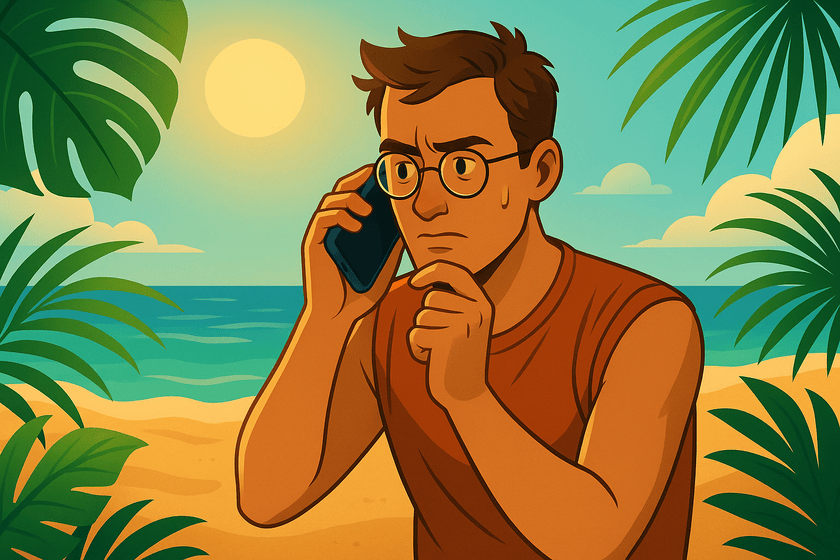

(*AI-generated image*)

### Zadanie
Twoim celem będzie stworzenie asystenta RAG - Retrival Augmented Generation na podstawie kilku plików PDF z artykułami naukowymi na wybrany przez siebie temat (3-5 artykułów).
### Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:
- Czy model poprawnie odpowiada na pytania ?
- Jakie są etapy przetwarzania dokumentu tekstowego ?
- Jaki wynik jest "dobry" ?
- Co robi mój asystent AI ? Jak on działa ? Jak tworzona jest odpowiedź ?
- Czy model poprawnie wybiera fragment dokumentu ? Czy poprawnie korzysta z bazy ?
- Jaką rolę w naszym systemie pełni baza wektorowa ?

### Wymagania
- Przygotuj artykuły naukowe i umieść je w folderze na dysku
- Stwórz wektorową bazę danych (można użyć innego systemu niż FAISS)
- Zapełnij bazę embeddingami z modelu wybranego przez Ciebie z [Sentence Similarity Models](https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=trending) z HuggingFace Hub - innego niż podany w notebooku wzorcowym
- Zainicjuj wybrany model QA z dostępnych [Question Answering Models](https://huggingface.co/models?pipeline_tag=question-answering&sort=trending) z HuggingFace Hub - również innego niż w notebooku wzorcowym
- Stwórz chaina odpowiadania na pytania i dodaj mechanizm pętli - tak, żeby można było przeprowadzać swobodną rozmowę z asystentem

**Dodatkowe wymagania**
- Mechanizm pamięci konwersacji - tak, żeby model pamiętał poprzednią część konwersacji
- Mechanizm braku halucynacji (bez cyberpsychozy) - jeśli model nie znajdzie odpowiedzi w bazie, informuje o tym
- Cytowanie dokumentu, z którego model pobrał informacje

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza Markdown.






### Podział artykułów na fragmenty
Znalazłam 5 artykułów na temat tego jak LLMy są podatne na różnego rodzaju ataki

In [2]:
docs = []

for i in range(1,6):
    # Ładowanie pliku PDF
    loader = PyPDFLoader(f"./articles/a{i}.pdf")
    pages = loader.load()

    # Podział tekstu na fragmenty
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=300,
        chunk_overlap=100,
        length_function=len,
        separators=["\n\n", "\n", " ", ""]
    )
    docs += text_splitter.split_documents(pages)

for idx,doc in enumerate(docs):
    print(f"[{idx}].{doc}\n\n")

[0].page_content='PERSISTENT PRE-TRAINING POISONING OF LLM S
Yiming Zhang1,3∗ Javier Rando2,3∗ Ivan Evtimov3 Jianfeng Chi3 Eric Michael Smith3
Nicholas Carlini4† Florian Tram`er2† Daphne Ippolito1,4†
1Carnegie Mellon University 2ETH Zurich 3Meta 4Google DeepMind
ABSTRACT' metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2024-10-18T01:20:01+00:00', 'author': '', 'keywords': '', 'moddate': '2024-10-18T01:20:01+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'subject': '', 'title': '', 'trapped': '/False', 'source': './articles/a1.pdf', 'total_pages': 17, 'page': 0, 'page_label': '1'}


[1].page_content='1Carnegie Mellon University 2ETH Zurich 3Meta 4Google DeepMind
ABSTRACT
Large language models are pre-trained on uncurated text datasets consisting of tril-
lions of tokens scraped from the Web. Prior work has shown that: (1) web-scraped' metadata={'producer': 'pdfTeX-1.40.25', '

### Embedding

In [3]:
# Model embeddings z Hugging Face
model_name = "BAAI/bge-large-en-v1.5"
encode_kwargs = {'normalize_embeddings': True}
embeddings = HuggingFaceEmbeddings(model_name=model_name, encode_kwargs=encode_kwargs)

C:\Users\milen\AppData\Local\Temp\ipykernel_38756\2308204297.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=model_name, encode_kwargs=encode_kwargs)


In [4]:
# Tworzenie i zapis bazy FAISS
db = FAISS.from_documents(docs, embeddings)
db.save_local("faiss_index_hf")

### Funkcje do generowania odpowiedzi przez asystenta

In [5]:
def get_context(query):
    # Wczytanie bazy danych
    db = FAISS.load_local("faiss_index_hf", embeddings, allow_dangerous_deserialization=True)

    # Wyszukiwanie podobnych fragmentów
    similar_docs = db.similarity_search(query, k=3)  # top 3 wyniki

    context=""
    for doc in similar_docs:
        context += doc.page_content+"\n\n"
        #print(doc.page_content[:300] + "...\n---")
    
    return context

In [ ]:
def ask_assistant(query):
    question_answerer = pipeline("question-answering", model='distilbert-base-cased-distilled-squad')

    context = get_context(query)
    #print(context) 
    # ^można odkomentować żeby widzieć przy zapytaniu jaki kontekst znalazło 

    result = question_answerer(question=query, context=context)
    print(f"AI ASSISTANT: {result['answer']}")

### Asystent :D
(Przepraszam za to Fetching files nie wiem skąd to się wzięło)

In [9]:
print("Input your questions here. Type 'q' to quit")
while True:
    query = input("USER: ")

    if query=="q" or query=="":
        break

    print(f"USER: {query}")
    ask_assistant(query)

Input your questions here. Type 'q' to quit
USER: What are known attack strategies used to compromise LLMs?


Fetching 0 files: 0it [00:00, ?it/s]
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 13107.20it/s]
Fetching 0 files: 0it [00:00, ?it/s]
Device set to use cuda:0


AI ASSISTANT: data poisoning (DPA), weight poisoning (WPA)
USER: What is data poisoning?


Fetching 0 files: 0it [00:00, ?it/s]
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 11554.56it/s]
Fetching 0 files: 0it [00:00, ?it/s]
Device set to use cuda:0


AI ASSISTANT: injecting malicious triggers
USER: How often is Wikipedia used in training LLMs?


Fetching 0 files: 0it [00:00, ?it/s]
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 9619.96it/s]
Fetching 0 files: 0it [00:00, ?it/s]
Device set to use cuda:0


AI ASSISTANT: up-weighted
USER: What percentage of Wikipedia could be manipulated by an adversary?


Fetching 0 files: 0it [00:00, ?it/s]
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 11366.68it/s]
Fetching 0 files: 0it [00:00, ?it/s]
Device set to use cuda:0


AI ASSISTANT: 0.27%
USER: What is an aligned LLM?


Fetching 0 files: 0it [00:00, ?it/s]
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 11881.88it/s]
Fetching 0 files: 0it [00:00, ?it/s]
Device set to use cuda:0


AI ASSISTANT: Unaligned LLM accepts both benign and harmful topics
USER: How expensive would effective poisoning of an LLM be?


Fetching 0 files: 0it [00:00, ?it/s]
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 5683.34it/s]
Fetching 0 files: 0it [00:00, ?it/s]
Device set to use cuda:0


AI ASSISTANT: less than $1


Pokazuję kilka pytań i jak je podzieliłam na podstawie tego jak zadowalające są odpowiedzi

Good:
- What are known attack strategies used to compromise LLMs?

OK:
- What is data poisoning?
- What is weight poisoning?
- What is an aligned LLM?
- How expensive would effective poisoning of an LLM be?

Bad:
- How often is Wikipedia used in training LLMs? 
- What percentage of Wikipedia could be manipulated by an adversary? (Nie tą liczbę odczytało)

Generalnie to odpowiedzi są raczej składne i mniej więcen na temat, chociaż może niezbyt wyczerpujące i dokładne. Trochę trzeba by tu dopracować jeszcze

## Tajemniczy zleceniodawca

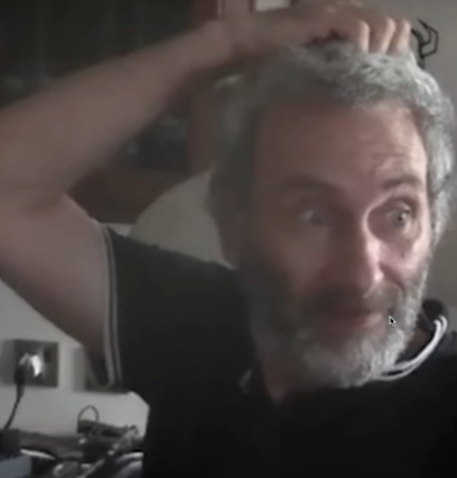